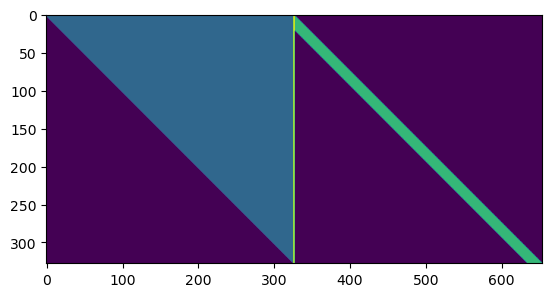

In [1]:
# import numpy as np
import matplotlib.pyplot as plt
from transport_map_plus_adapt_52_more_information import *
import time
import pickle

np.random.seed(0)

plt.close("all")

# Number of dimensions
D       = 654

# Create the dummy matrix
map_orders = np.zeros((D,D),dtype=int)

order_row_a_col_y = 3
order_row_s_col_y = 1
order_row_a_col_a = 3
order_row_s_col_s = 2

order_row_s_col_a = 3

# Add subblocks
map_orders[:326,:326] += np.tril(np.ones((326,326),dtype=int))
map_orders[326:328,:326] += np.ones((2,326),dtype=int)*order_row_a_col_y
map_orders[326:328,326:328] += np.tril(np.ones((2,2),dtype=int))*order_row_a_col_a
map_orders[-326:,:326] += np.triu(np.ones((326,326),dtype=int))*order_row_s_col_y
map_orders[-326:,328:] += np.tril(np.ones((326,326),dtype=int))*order_row_s_col_s
map_orders[-326:,328:] -= np.tril(np.ones((326,326),dtype=int),k=-20)*order_row_s_col_s

map_orders[-326:,326:328] += np.ones((326,2),dtype=int)*order_row_s_col_a

map_orders = map_orders[326:,:]

plt.imshow(map_orders)

# Define the map parameterization

In [2]:
start_time  = time.time()

# These variables define the maximum polynomial order for the nonmonotone
# and monotone terms in the transport map
maxorder_nonmonotone    = 1
maxorder_monotone       = 1

# Now start building the map parameterization
monotone    = []
nonmonotone = []

print("Formulating map parameterization...",end=" ")

# Specify the map components
for k in range(map_orders.shape[0]):

    # Level 1: One list entry for each dimension (two in total)
    monotone.append([])
    nonmonotone.append([[]]) # An empty list "[]" denotes a constant

    # Monotone part -------------------------------------------------------

    # Go through each polynomial order
    for order in range(map_orders[k,k+326]):

        # The first term is linear
        if order == 0:

            monotone[-1].append([k+326])

        # All subsequent terms are integrated radial basis functions
        else:

            monotone[-1].append('iRBF '+str(k+326))

    # Nonmonotone part ----------------------------------------------------

    # Go through every potential off-diagonal entry
    for j in range(326+k):

        # That map entry exists
        if map_orders[k,j] > 0:

            # Go through each polynomial order
            for order in range(map_orders[k,j]):

                # Linear terms have no edge control modifier
                if order == 0:

                    nonmonotone[-1].append([j])

                # Nonlinear terms do
                else:

                    nonmonotone[-1].append([j]*(order+1)+['EC'])

print("Done. ("+"{:.2f}".format(time.time()-start_time)+" seconds)")

Formulating map parameterization... Done. (0.08 seconds)


In [3]:
runName = "dark"
year = "2014"

ensDir = "/Users/kmleung/Documents/JPLspatial/AOE.jl/examples/transport/ensembles/" + runName + ".p"
yobsDir = "data/y_" + runName + ".npy"
mcmcChainDir = "/Users/kmleung/Documents/JPLproject/resultsGibbs/" + runName + "_SNR50_RandWalkIsofitCovEps0_11_2M/mcmcchain.npy"
xtruthDir = "data/x_" + runName + ".npy"
xisofitMuDir = "data/x_iso_" + runName + ".npy"
xisofitGammaDir = "data/x_iso_gamma_" + runName + ".npy"

# Build the transport map

In [4]:
start_time  = time.time()

map_input   = pickle.load(open(ensDir, "rb")).T

map_input_orig = np.copy(map_input)


# # convert atm to span -inf to inf
aod = map_input[:,326]
h2o = map_input[:,327]
map_input[:,326] = 1 * np.log(aod) 
map_input[:,327] = 1 * np.log(h2o) 


N = map_input.shape[0]

# raise Exception

print("Initiating the transport map...")

# Build the map
tm  = transport_map(
    X               = map_input, # Training samples
    nonmonotone     = nonmonotone, # Map parameterization for nonmonotone terms
    monotone        = monotone, # Map parameterization for monotone terms
    polynomial_type = "edge-controlled hermite", # Type of polynomials used in the map parameterization
    weight_type     = "cubic spline", # Type of weight term used for edge-controlled hermites
    monotonicity    = "separable monotonicity", # How does the map enforce monotonicity?
    workers         = 1, # Number of workers for optimization (> 1 is parallel) WARNING: currently, overhead seems to eat any gains
    verbose         = True) # Flag determining whether the map object is silent or not

print("Done. ("+"{:.2f}".format(time.time()-start_time)+" seconds)")

Initiating the transport map...
Constructing map component functions... Done.   
Precalculating basis function evaluations... Done.   
Done. (27.61 seconds)


# Optimize the transport map

In [5]:
start_time  = time.time()

print("Optimizing map...", end=" ")

# Build the map
tm.optimize()

print("Done. ("+"{:.2f}".format(time.time()-start_time)+" seconds)")

Done. (51.24 seconds)██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|                 |


# Condition on observation

In [6]:
start_time  = time.time()

# Load observation
y_obs       = np.load(yobsDir)

# Apply the forward map to obtain pushfoward samples Z
Z = tm.map(map_input)

# Conditionally invert the map
X_star = tm.inverse_map(
    X_star  = np.repeat(y_obs[np.newaxis,:],axis=0,repeats=N), # Upper block: All samples are conditioned on the same observation
    Z       = Z) # Lower block: the pushforward samples we obtained before

print("Done. ("+"{:.2f}".format(time.time()-start_time)+" seconds)")


# # convert atm back to original space
aod = X_star[:,0]
h2o = X_star[:,1]
X_star[:,0] = np.exp(aod / 1)
X_star[:,1] = np.exp(h2o / 1)

# save data for plotting
np.save("transportResults/sampTransport_" + runName + ".npy", X_star)

Done. (21.23 seconds)


In [7]:
# load npy mcmc chain
mcmcChain = np.load(mcmcChainDir)
mcmcChain = mcmcChain[:,::20]


print(mcmcChain.shape)
bands = np.load("data/wl_ind_" + year + ".npy")
mcmcmean = np.mean(mcmcChain[bands,:],1)
mcmccov = np.cov(mcmcChain[bands,:])
print(np.shape(mcmccov))

(434, 10000)
(326, 326)


# Plot results

<Figure size 640x480 with 0 Axes>

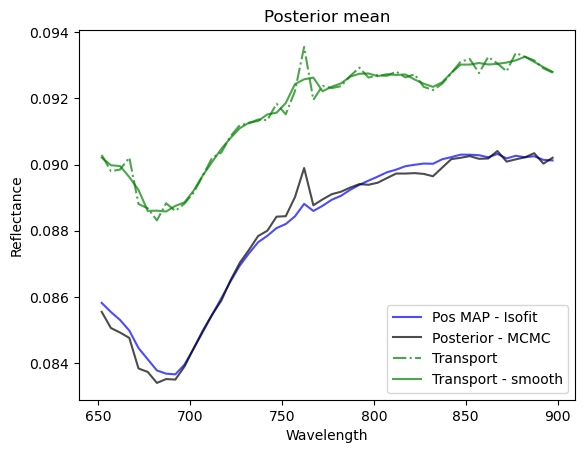

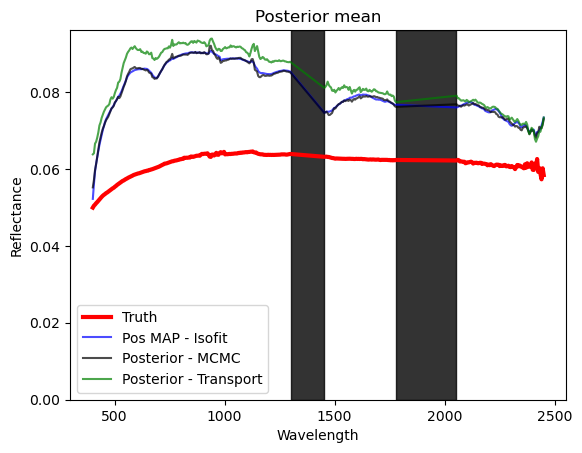

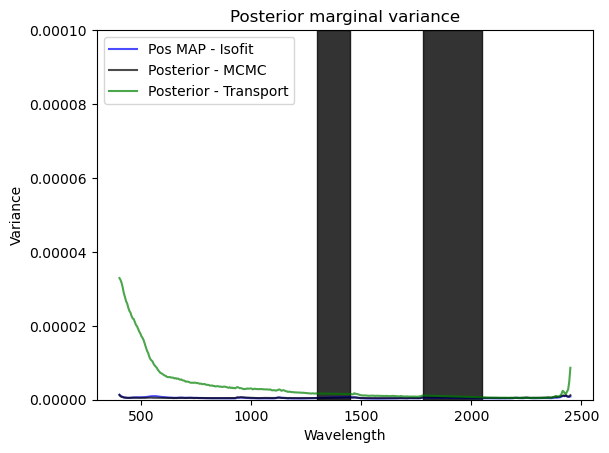

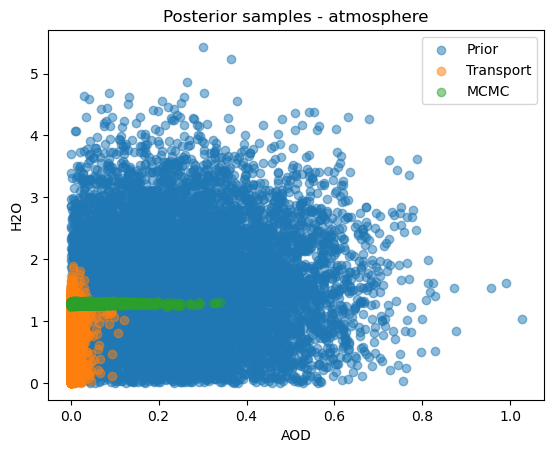

In [8]:
plt.figure()
wls = np.load('data/wls.npy')
x_truth = np.load(xtruthDir)
x_isofit_mu = np.load(xisofitMuDir)
x_isofit_gamma = np.load(xisofitGammaDir)
n = len(wls)

X_star_refl = X_star[:,2:]
mu_pos = np.mean(X_star_refl, 0)
gamma_pos = np.cov(X_star_refl.T)

# import copy
# mu_pos_smooth = copy.deepcopy(mu_pos)
# window = 3
# def smooth(y, box_pts):
#     box = np.ones(box_pts)/box_pts
#     y_smooth = np.convolve(y, box, mode='same')
#     return y_smooth
# mu_pos_smooth[window:-window] = smooth(mu_pos, window)[window:-window]


plt.figure()
plt.plot(wls[50:100], x_isofit_mu[50:100], 'b', alpha=0.7, label="Pos MAP - Isofit")
plt.plot(wls[50:100], mcmcmean[50:100], 'k', alpha=0.7, label="Posterior - MCMC")
plt.plot(wls[50:100], mu_pos[50:100], 'g-.', alpha=0.7, label="Transport")
plt.plot(wls[50:100], mu_pos_smooth[50:100], 'g', alpha=0.7, label="Transport - smooth")
plt.xlabel("Wavelength")
plt.ylabel("Reflectance")
plt.title("Posterior mean")
plt.legend()


plt.figure()
plt.plot(wls, x_truth, 'r', alpha=1, linewidth=3,label="Truth")
plt.plot(wls, x_isofit_mu, 'b', alpha=0.7, label="Pos MAP - Isofit")
plt.plot(wls, mcmcmean, 'k', alpha=0.7, label="Posterior - MCMC")
plt.plot(wls, mu_pos, 'g', alpha=0.7, label="Posterior - Transport")
plt.axvspan(1300, 1450, alpha=0.8, color='black')
plt.axvspan(1780, 2050, alpha=0.8, color='black')
plt.ylim(bottom=0)
plt.xlabel("Wavelength")
plt.ylabel("Reflectance")
plt.title("Posterior mean")
plt.legend()
plt.savefig('refl_pos_mean_' + runName + '.png', dpi=300)


plt.figure()
plt.plot(wls, np.diag(x_isofit_gamma), 'b', alpha=0.7, label="Pos MAP - Isofit")
plt.plot(wls, np.diag(mcmccov), 'k', alpha=0.7, label="Posterior - MCMC")
plt.plot(wls, np.diag(gamma_pos), 'g', alpha=0.7, label="Posterior - Transport")
plt.axvspan(1300, 1450, alpha=0.8, color='black')
plt.axvspan(1780, 2050, alpha=0.8, color='black')
plt.ylim(bottom=0, top=0.0001)
plt.xlabel("Wavelength")
plt.ylabel("Variance")
plt.title("Posterior marginal variance")
plt.legend()
plt.savefig('refl_pos_var_' + runName + '.png', dpi=300)

plt.figure()
plt.scatter(map_input_orig[:,326], map_input_orig[:,327], alpha=0.5,label='Prior')
plt.scatter(X_star[:,0], X_star[:,1], alpha=0.5,label='Transport')
plt.scatter(mcmcChain[-2,:], mcmcChain[-1,:], alpha=0.5,label='MCMC')
plt.xlabel('AOD')
plt.ylabel('H2O')
plt.legend()
plt.title('Posterior samples - atmosphere')
plt.savefig('atm_pos_samp_' + runName + '.png', dpi=300)


plt.show()

# Plots for analysis

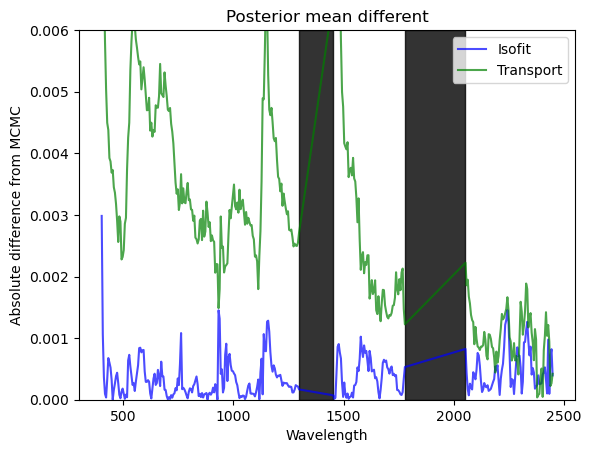

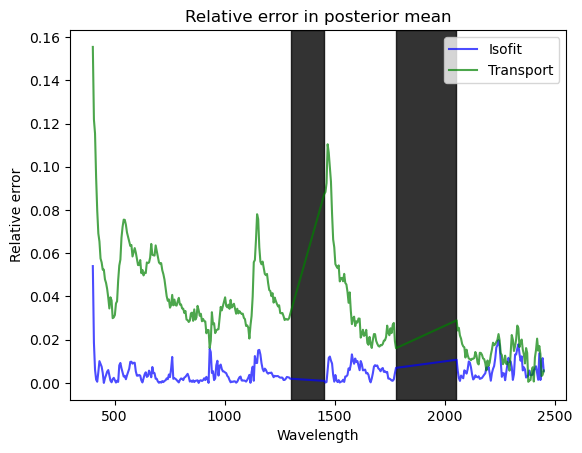

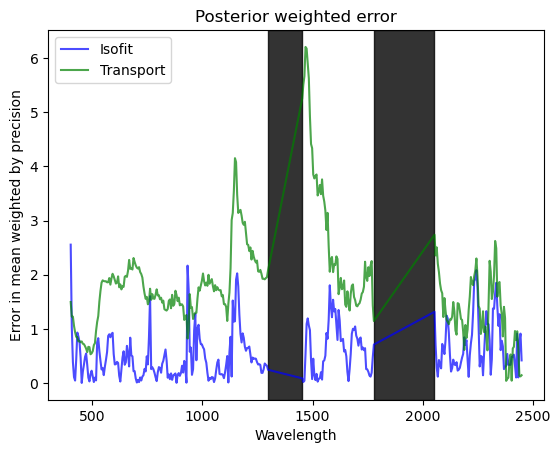

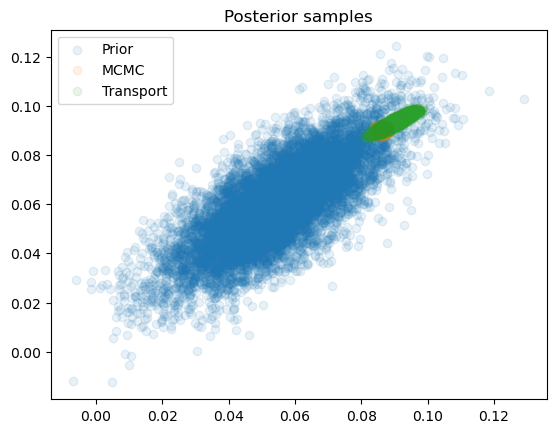

In [9]:
# from seaborn import heatmap
# plt.figure()
# heatmap(np.log(gamma_pos), vmin=-24, vmax=-8)
# plt.figure()
# heatmap(np.log(mcmccov), vmin=-24, vmax=-8) 

relerr_isofit =  abs(x_isofit_mu - mcmcmean) / abs(mcmcmean)
relerr_transport  =  abs(mu_pos - mcmcmean) / abs(mcmcmean)
weighterr_isofit =  abs(x_isofit_mu - mcmcmean) / np.sqrt(np.diag(x_isofit_gamma))
weighterr_transport = abs(mu_pos - mcmcmean) / np.sqrt(np.diag(gamma_pos))

# plt.figure()
# plt.plot(wls, np.sqrt(np.diag(x_isofit_gamma)), 'b', alpha=0.7, label="Pos MAP - Isofit")
# plt.plot(wls, np.sqrt(np.diag(mcmccov)), 'k', alpha=0.7, label="Posterior - MCMC")
# plt.plot(wls, np.sqrt(np.diag(gamma_pos)), 'g', alpha=0.7, label="Posterior - Transport")
# plt.axvspan(1300, 1450, alpha=0.8, color='black')
# plt.axvspan(1780, 2050, alpha=0.8, color='black')
# plt.ylim(bottom=0, top=0.006)
# plt.xlabel("Wavelength")
# plt.ylabel("Standard Deviation")
# plt.title("Posterior marginal stddev")
# plt.legend()
# plt.savefig('refl_pos_var.png', dpi=300)

plt.figure()
plt.plot(wls, abs(x_isofit_mu - mcmcmean), 'b', alpha=0.7, label="Isofit")
plt.plot(wls, abs(mu_pos - mcmcmean),'g', alpha=0.7, label="Transport")
plt.axvspan(1300, 1450, alpha=0.8, color='black')
plt.axvspan(1780, 2050, alpha=0.8, color='black')
plt.ylim(bottom=0, top=0.006)
plt.xlabel("Wavelength")
plt.ylabel("Absolute difference from MCMC")
plt.title("Posterior mean different")
plt.legend()

plt.figure()
plt.plot(wls, relerr_isofit, 'b', alpha=0.7, label="Isofit")
plt.plot(wls, relerr_transport,'g', alpha=0.7, label="Transport")
plt.axvspan(1300, 1450, alpha=0.8, color='black')
plt.axvspan(1780, 2050, alpha=0.8, color='black')
# plt.ylim(bottom=0, top=0.006)
plt.xlabel("Wavelength")
plt.ylabel("Relative error")
plt.title("Relative error in posterior mean")
plt.legend()

plt.figure()
plt.plot(wls, weighterr_isofit, 'b', alpha=0.7, label="Isofit")
plt.plot(wls, weighterr_transport,'g', alpha=0.7, label="Transport")
plt.axvspan(1300, 1450, alpha=0.8, color='black')
plt.axvspan(1780, 2050, alpha=0.8, color='black')
# plt.ylim(bottom=0, top=0.006)
plt.xlabel("Wavelength")
plt.ylabel("Error in mean weighted by precision")
plt.title("Posterior weighted error")
plt.legend()

plt.figure()
b1, b2 = [50, 100]
plt.scatter(map_input_orig[:,328+b1], map_input_orig[:,328+b2], alpha=0.1,label='Prior')
plt.scatter(mcmcChain[b1,:], mcmcChain[b2,:], alpha=0.1,label='MCMC')
plt.scatter(X_star[:,b1-2], X_star[:,b2-2], alpha=0.1,label='Transport')
# plt.xlabel('AOD')
# plt.ylabel('H2O')
plt.legend()
plt.title('Posterior samples')





plt.show()




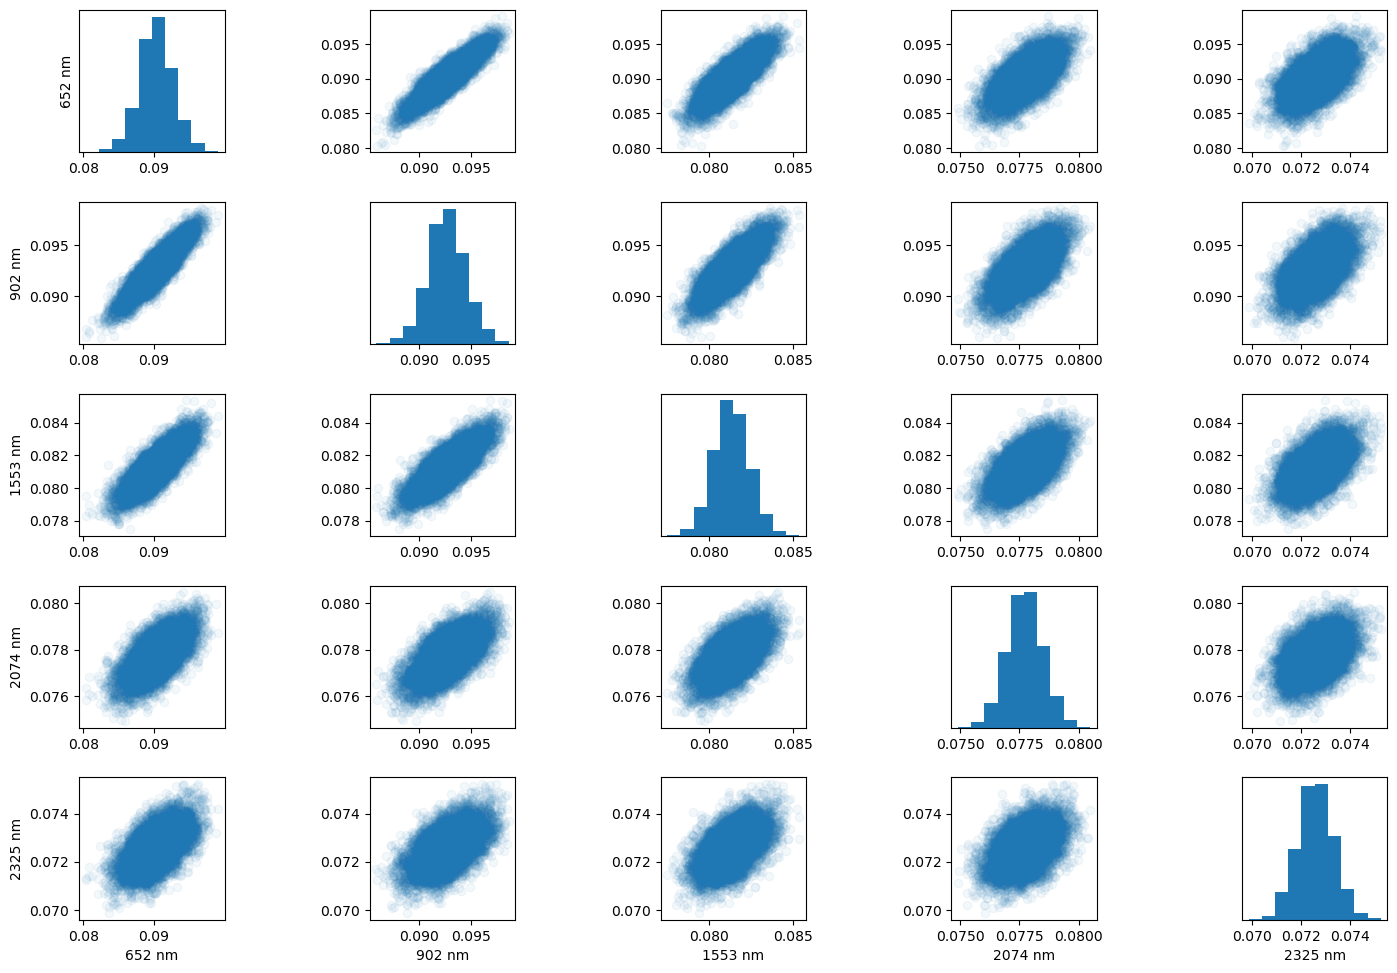

In [10]:
ij = [50,100,200,250,300]
numInd = len(ij)
fig,ax = plt.subplots(numInd,numInd)

for i in range(numInd):
    for j in range(numInd):
        if i == j:
            ax[i,i].hist(X_star_refl[:,ij[i]])
            ax[i,i].get_yaxis().set_ticks([])
        else:
            ax[j,i].scatter(X_star_refl[:,ij[i]], X_star_refl[:,ij[j]], alpha=0.05)
        if i == numInd-1:
            ax[i,j].set_xlabel(str(round(wls[ij[j]])) + ' nm')
        if j == 0:
            ax[i,j].set_ylabel(str(round(wls[ij[i]])) + ' nm')
# plt.legend()
fig.tight_layout(pad=0)
fig.set_figwidth(15)
fig.set_figheight(10)
# plt.title('Posterior samples')

plt.savefig('refl_pos_samp.png', dpi=300)

0.07483214729508621 0.004853928920540505
[0.08339473 0.07677448 0.07958287 0.08570928 0.08389714 0.07008851
 0.07944381 0.07409747 0.07433113 0.07682516]
[0.07210888 0.08156574 0.0715135  ... 0.07040617 0.07341557 0.07631107]
KstestResult(statistic=0.014376891238529699, pvalue=0.03173167229027096)
AOD p-value: 0.0
H2O p-value: 8.798357832508911e-34


<Figure size 640x480 with 0 Axes>

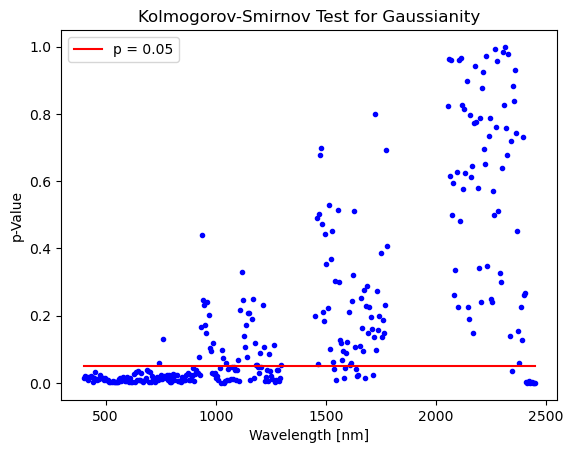

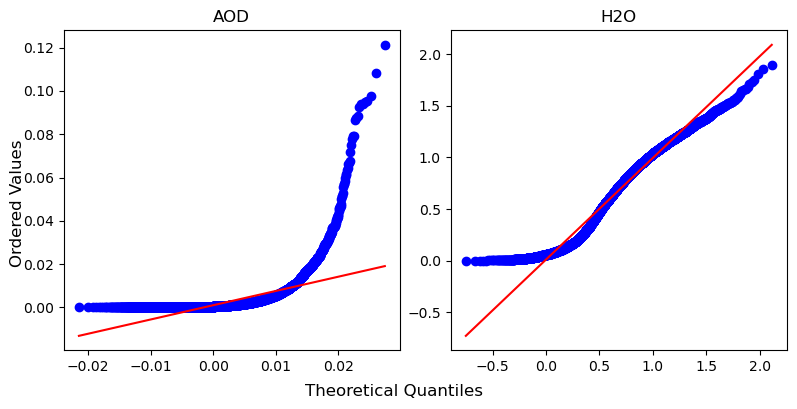

In [11]:
from scipy.stats import kstest, norm, probplot, truncnorm

plt.figure()
KSref = np.zeros(n)
# plt.plot(np.sqrt(np.diag(gamma_pos)))
for i in range(n):
    normDist = norm(loc=mu_pos[i], scale=np.sqrt(gamma_pos[i,i]))
#     normDist = norm(loc=mu_pos[i], scale=np.sqrt(var_pos[i]))


    KSref[i] = kstest(X_star_refl[:,i], normDist.cdf).pvalue
    if i == 10:
        
        print(mu_pos[i], np.sqrt(gamma_pos[i,i]))
        print(np.random.normal(loc=mu_pos[i], scale=np.sqrt(gamma_pos[i,i]), size=10))
        print(X_star_refl[:,i])
        print(kstest(X_star_refl[:,i], normDist.cdf))
lineX = [wls[0], wls[-1]]
lineY = [0.05, 0.05]

# i = 10
# fig = plt.figure()
# ax = fig.add_subplot(111)
# normDist = norm(loc=mu_pos[i], scale=np.sqrt(gamma_pos[i,i]))
# # tnormAOD = norm(loc=np.mean(X_star[:,0]), scale=np.sqrt(np.cov(X_star[:,0])))
# probplot(X_star_refl[:,i], dist=normDist, plot=ax)
# # i = 10
# # print('Mu: ',mu_pos[i])
# # print('Std:', np.sqrt(gamma_pos[i,i]))
# # print('Std:', np.std(X_star_refl[:10,i]))
# # print('Samples', X_star_refl[:10,i])


# print(KSref)

plt.figure()
plt.plot(wls, KSref, 'b.')
plt.plot(lineX, lineY, 'r-', label='p = 0.05')
plt.xlabel('Wavelength [nm]')
plt.ylabel('p-Value')
plt.title('Kolmogorov-Smirnov Test for Gaussianity')
plt.legend()

fig, ax = plt.subplots(1,2)
tnormAOD = norm(loc=np.mean(X_star[:,0]), scale=np.sqrt(np.var(X_star[:,0])))
probplot(X_star[:,0], dist=tnormAOD, plot=ax[0])
tnormH2O = norm(loc=np.mean(X_star[:,1]), scale=np.sqrt(np.var(X_star[:,1])))
probplot(X_star[:,1], dist=tnormH2O, plot=ax[1])
for i in range(2):
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('')
ax[0].set_title('AOD')
ax[1].set_title('H2O')
fig.supxlabel('Theoretical Quantiles')
fig.supylabel('Ordered Values')
fig.set_size_inches(8, 4)
fig.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)

print('AOD p-value:',kstest(X_star[:,0], tnormAOD.cdf).pvalue)
print('H2O p-value:',kstest(X_star[:,1], tnormH2O.cdf).pvalue)


plt.show()
